<a href="https://colab.research.google.com/github/moisesortega93/MCME-AI/blob/main/Recommenders_and_clustering_ESP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PEC1: Recomendadores y agrupación:**

Este archivo de cuaderno interactivo de jupyter le ayudará a comenzar con las operaciones básicas necesarias para resolver los ejercicios del PEC. Utilice este archivo para proporcionar una solución a los ejercicios (tanto el código como los comentarios escritos). Agregue tantas celdas de código y de texto como necesite para resolver todos los ejercicios. Asegúrate de que el archivo se puede ejecutar completamente antes de cargarlo para su entrega.

### Instalar las librerías suprise en google colab:

In [2]:
!pip install scikit-surprise
!pip install sklearn

import surprise

     |████████████████████████████████| 11.8MB 5.7MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617550 sha256=adec82f0be235c1ce575543692f95aa84589c6de5ca3ce9aef81da7ce0194484
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


## **Ejercicio 1: Manipulación de datos con surprise and Pandas:**

Este primer ejercicio es para familiarizarse con el conjunto de datos de Jester y cómo realizar la manipulación básica de datos usando Pandas.


a) Cargar la base de datos Jester desde el surprise dataset

In [2]:
from surprise import Dataset

data = Dataset.load_builtin('jester')


Dataset jester could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from http://eigentaste.berkeley.edu/dataset/archive/jester_dataset_2.zip...
Done! Dataset jester has been saved to /root/.surprise_data/jester


Convertir los datos a un Pandas dataframe

In [5]:
import pandas as pd
df = pd.DataFrame(data.__dict__['raw_ratings'], columns=['user_id', 'item_id', 'rating', 'timestamp'])
print(df.shape)

(1761439, 4)


Realizar inspección y manipulación básica de los datos:

Enumere las 10 primeras entradas del conjunto de datos:


In [4]:
df.head(10) 

,user_id,item_id,rating,timestamp
0,1,5,0.219,None
1,1,7,-9.281,None
2,1,8,-9.281,None
3,1,13,-6.781,None
4,1,15,0.875,None
5,1,16,-9.656,None
6,1,17,-9.031,None
7,1,18,-7.469,None
8,1,19,-8.719,None
9,1,20,-9.156,None


¿Cuántas entradas hay en el conjunto de datos?

In [5]:
df.shape[0] # 0: number of rows, 1: number of columns/variables
len(df)
df.__len__()

1761439

¿Cuántos usuarios y chistes hay en la base de datos?

In [6]:
print('Number of users:')
df["user_id"].nunique() # number of users
len(df.groupby(['user_id']))

Number of users:


59132

In [60]:
print('Number of items:')
df["item_id"].nunique() # number of items
len(df.groupby(['user_id']))

Number of items:


59132

¿Cuál es la calificación del usuario con user_id = 1 de la chiste con item_id = 5?


In [7]:
df.loc[(df["user_id"]=='1') & (df["item_id"]=='5')]
df.loc[(df["user_id"]=='1') & (df["item_id"]=='5'),"rating"].values[0]

# Alternatively 
df.iloc[[i for i, x in enumerate((df["user_id"]=='1') & (df["item_id"]=='5')) if x], 2]  # or
#df.iloc[[i for i, x in enumerate((df["user_id"]=='1') & (df["item_id"]=='5')) if x], [x for x, i in enumerate(df.columns) if x=="rating"] ] 
name=1;
print("La califación del user_id ", name, " es: ", df.loc[(df["user_id"]=='1') & (df["item_id"]=='5'),"rating"].values[0], sep='')


La califación del user_id 1 es: 0.219


b) Filtrar el conjunto de datos:

Filtre la base de datos manteniendo solo los elementos que hayan calificado al menos min_item_ratings usuarios y usuarios que hayan calificado al menos los elementos min_user_ratings:

In [8]:
min_user_ratings = 130
filter_users = df['user_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_small = df[(df['item_id'].isin(filter_items)) & (df['user_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_small.shape))

The original data frame shape:	(1761439, 4)
The new data frame shape:	(1325, 4)


Convierta el marco de datos de nuevo a una variable surprise utilizando las funciones reader y load_from_df:

https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset

In [9]:
from surprise import Reader 
reader = Reader(rating_scale=(-10, 10))
data_small = Dataset.load_from_df(df_small[['user_id', 'item_id', 'rating']], reader)

Responde las siguientes preguntas:

- ¿Cuántos usuarios y elementos hay en el conjunto de datos reducido?


In [10]:
df_small.__len__()

df_small = pd.DataFrame(data_small.__dict__['raw_ratings'], columns=['user_id', 'item_id', 'rating', 'timestamp'])
print("El conjunto de datos reducido df_small contiene {} elementos".format(df_small.shape[0]))
len(df_small)

El conjunto de datos reducido df_small contiene 1325 elementos


1325

- Proporcione una breve descripción de las principales características del conjunto de datos.



In [10]:
df_small.head()

#df_small.drop(['timestamp'], axis=1)
df_small.describe()
#df_small.info()



,rating
count,1325.000000
mean,2.346844
std,5.032869
min,-9.844000
25%,-1.438000
50%,3.500000
75%,6.281000
max,9.969000


c) Proporcione una representación gráfica de la distribución del número de usuarios con un determinado número de valoraciones. ¿Cuáles son las principales conclusiones que se pueden sacar de este gráfico ?


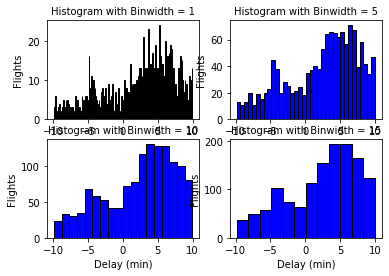

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns

for i, binwidth in enumerate([1, 5, 10, 15]):
    
    # Set up the plot
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(df_small['rating'], bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    
    # Title and labels
    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 10)
    ax.set_xlabel('Delay (min)', size = 10)
    ax.set_ylabel('Flights', size= 10)



## **Ejercicio 2: Diferentes formas de diseñar un sistema de recomendación**
En este ejercicio estamos explorando diferentes formas de diseñar / entrenar un sistema de recomendación. A menos que se indique lo contrario, este ejercicio se realizará con el conjunto de datos reducido obtenido en el ejercicio anterior.



a) Ajuste un recomendador de descomposición de valores singulares utilizando como datos de entrenamiento todo el conjunto de datos reducido. ¿Cuál es la tasa prevista de user_id = 46 del chiste con item_id = 44 ?. ¿Cuál es la discrepancia entre la qualificació prevista y la real? Evalúe el rendimiento de este enfoque utilizando RMSE, MAE y MSE como métricas de precisión.


In [11]:
# Build an algorithm, and train it.
from surprise import SVD
from surprise import KNNBasic
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset (download it if needed).

trainset = data_small.build_full_trainset()

# Use the famous SVD algorithm.
mSVD = SVD()
mSVD.fit(trainset)


#mSVD.fit(df_small)
# Run 5-fold cross-validation and print results.
#cross_validate(mSVD, data, measures=['RMSE', 'MAE', "MSE"], cv=5, verbose=True)


uid = str(46)  # raw user id (as in the ratings file). They are **strings**!
iid = str(44)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = mSVD.predict(uid, iid, r_ui=4, verbose=True)
print("Prediction for user ", pred.iid,"is:",round(pred.est))
print("Real value is: ", pred.r_ui," Predicted:",round(pred.est,3), "Error:", round(pred.r_ui-pred.est,3))


user: 46         item: 44         r_ui = 4.00   est = 6.56   {'was_impossible': False}
Prediction for user  44 is: 7
Real value is:  4  Predicted: 6.558 Error: -2.558


b) Ajuste el mismo recomendador pero ahora dividiendo los datos en subconjuntos de entrenamiento y prueba en tres proporciones diferentes (entrenamiento / prueba): 90/10, 75/25 y 10/90. Compare el RMSE, MAE y MSE promedio cuando utilice diferentes fracciones para los subconjuntos de entrenamiento y prueba. ¿Qué proporción produce mejores resultados de predicción? Justifica tu respuesta.


In [12]:
from surprise import model_selection
from surprise import SVD

for size in [0.1, 0.25,0.9]:

  trainset, testset = model_selection.train_test_split(data, test_size=size)

  # We'll use the famous SVD algorithm.
  mSVD = SVD()

  # Train the algorithm on the trainset, and predict ratings for the testset
  mSVD.fit(trainset)
  predictions = mSVD.test(testset)

  # Then compute RMSE
  print("Accuracy measures SVD with (entrenamiento",round((1-size)*100),"% / prueba",round(size*100),"% ):")
  print("RMSE    = " + str("{:10.3f}".format(surprise.accuracy.rmse(predictions,verbose=False))))

  print("MSE     = " + str("{:10.3f}".format(surprise.accuracy.mse(predictions,verbose=False))))

  print("MAE     = " + str("{:10.3f}".format(surprise.accuracy.mae(predictions,verbose=False))))

  print("FCP     = " + str("{:10.3f}".format(surprise.accuracy.fcp(predictions,verbose=False))))

Accuracy measures SVD with (entrenamiento 90 % / prueba 10 % ):
RMSE    =      4.520
MSE     =     20.428
MAE     =      3.376
FCP     =      0.561
Accuracy measures SVD with (entrenamiento 75 % / prueba 25 % ):
RMSE    =      4.476
MSE     =     20.034
MAE     =      3.358
FCP     =      0.577
Accuracy measures SVD with (entrenamiento 10 % / prueba 90 % ):
RMSE    =      4.623
MSE     =     21.375
MAE     =      3.662
FCP     =      0.584


c) Ajuste y evalúe ahora el recomendador de SVD utilizando un procedimiento de validación cruzada de 5 veces (cv = 5). Compare los resultados medios con el rendimiento obtenido en los apartados anteriores. Explique las diferencias de forma razonada.


In [13]:
from surprise import model_selection
from surprise import SVD
mSVD = SVD()
model_selection.cross_validate(mSVD, data,measures=['RMSE',"MSE", 'MAE'], cv=5)



{'fit_time': (82.6424822807312,
  82.868497133255,
  83.33421087265015,
  82.9361789226532,
  82.61983728408813),
 'test_mae': array([3.36771936, 3.36683015, 3.37640816, 3.36941315, 3.37103025]),
 'test_mse': array([20.18973574, 20.17449942, 20.32784893, 20.20532821, 20.25909869]),
 'test_rmse': array([4.49329898, 4.49160321, 4.50864158, 4.49503373, 4.50101085]),
 'test_time': (5.018828868865967,
  5.048227787017822,
  3.418773651123047,
  4.979236602783203,
  4.794638395309448)}

d) Use una validación cruzada de 5 veces para comparar el desempeño de las versiones sesgadas e imparciales del recomendador de SVD descrito en https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization. SVD. ¿Qué método proporciona una mejor precisión de predicción? ¿Por qué?


In [50]:

mSVD=SVD(biased=True)
model_selection.cross_validate(mSVD, data,measures=['RMSE',"MSE", 'MAE'], cv=5)

mSVD=SVD(biased=False)
model_selection.cross_validate(mSVD, data,measures=['RMSE',"MSE", 'MAE'], cv=5)


{'fit_time': (4.963589906692505,
  5.047118663787842,
  4.903257846832275,
  4.9221813678741455,
  5.320152521133423),
 'test_mae': array([0.73515622, 0.73885067, 0.73872665, 0.74153071, 0.74269779]),
 'test_mse': array([0.87073257, 0.87873927, 0.87950833, 0.88662983, 0.88128805]),
 'test_rmse': array([0.93313052, 0.93741094, 0.93782105, 0.94161023, 0.93876943]),
 'test_time': (0.18441510200500488,
  0.17510223388671875,
  0.18646764755249023,
  0.17888474464416504,
  0.190568208694458)}

e) Confirme la comparación entre los algoritmos SVD sesgados e insesgados realizando una validación cruzada de búsqueda de cuadrícula https://surprise.readthedocs.io/en/stable/getting_started.html#tune-algorithm-parameters-with-gridsearchcv

In [40]:
from surprise import SVD
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [1, 5, 10,20,50],
              'n_epochs': [5, 10], 
              'lr_all': [0.001,0.0025, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae',"mse"], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score)

# combination of parameters that gave the best RMSE score
print(gs.best_params)

{'rmse': 4.4734109450843595, 'mae': 3.598575906000919, 'mse': 20.032052045371103}
{'rmse': {'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}, 'mae': {'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}, 'mse': {'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}}


## **Ejercicio 3: Comparar algoritmos de agrupamiento con datos sintéticos**
En esta sección, comparará dos de los algoritmos de agrupación en clúster más comunes que utilizan datos generados sintéticamente.



a) Utilice la función make_blobs de la biblioteca sklearn para generar 1500 observaciones bidimensionales distribuidas equitativamente en tres grupos centrados en las posiciones (0,0), (4,4) y (6,6). La descripción de la función se puede encontrar aquí:
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html


<bound method NDFrame.head of              x         y  label
0     5.712305  3.207885      1
1     6.826126  5.942243      2
2     4.459585  4.280058      1
3     0.470433  0.311447      0
4     0.448195  1.696182      0
...        ...       ...    ...
1495 -0.652294 -0.521189      0
1496 -0.035768  2.380745      0
1497 -0.908763 -0.424318      0
1498  3.960732  3.051067      1
1499 -0.028182  0.428332      0

[1500 rows x 3 columns]>


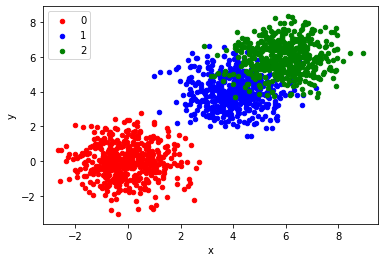

In [1]:
from sklearn import datasets
import pandas as pd
from matplotlib import pyplot

X, y = datasets.make_blobs(n_samples=1500, centers=[[0,0],[4,4],[6,6]], n_features=2, random_state=0)

df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
print(df.head)
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()




b) Agrupar los datos usando un algoritmo de k-medias con k = 3 y un método de agrupamiento jerárquico / aglomerativo con tres grupos. Represente gráficamente los resultados con diagramas de dispersión usando diferentes colores para cada uno de los grupos identificados por los dos métodos. Compare los resultados de la agrupación en clústeres. ¿Qué método es mejor cuando el verdadero centroide de los grupos se acerca?


In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
##K-means

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

kmeans.labels_



array([2, 0, 2, ..., 1, 2, 1], dtype=int32)

c) Repita las tareas de las dos secciones anteriores, pero ahora genere las observaciones con las siguientes varianzas desiguales: 1, 2.5 y 0.5 respectivamente. Comente los resultados.